# Install and Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)
%matplotlib inline

# Load data

In [2]:
df = pd.read_csv('../loan-approval/dataset/data.csv', encoding= 'utf-8')
df.shape

(614, 13)

# Descriptive Analysis

In [3]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df = df.convert_dtypes()
df['Credit_History'] = df['Credit_History'].astype('string')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    string 
 1   Gender             601 non-null    string 
 2   Married            611 non-null    string 
 3   Dependents         599 non-null    string 
 4   Education          614 non-null    string 
 5   Self_Employed      582 non-null    string 
 6   ApplicantIncome    614 non-null    Int64  
 7   CoapplicantIncome  614 non-null    Float64
 8   LoanAmount         592 non-null    Int64  
 9   Loan_Amount_Term   600 non-null    Int64  
 10  Credit_History     564 non-null    string 
 11  Property_Area      614 non-null    string 
 12  Loan_Status        614 non-null    string 
dtypes: Float64(1), Int64(3), string(9)
memory usage: 64.9 KB


## Deleting ID column

In [5]:
df['Loan_ID'].value_counts().sort_values(ascending=False)

LP001002    1
LP002318    1
LP002301    1
LP002348    1
LP002305    1
           ..
LP001691    1
LP001692    1
LP001693    1
LP001698    1
LP002990    1
Name: Loan_ID, Length: 614, dtype: Int64

In [6]:
df.drop('Loan_ID', axis= 1, inplace= True)

ID of Loan is a unecessary feature to train the predictive model.

## NaN analysis

In [7]:
def highlight_nans(val):
    return 'background-color: lightcoral' if val != 0 else ''

In [8]:
df.isnull().sum().to_frame().rename(columns= {0:'NaN values'}).style.applymap(highlight_nans)

,NaN values
Gender,13
Married,3
Dependents,15
Education,0
Self_Employed,32
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,22
Loan_Amount_Term,14
Credit_History,50


### Numerical features

In [9]:
df[['LoanAmount','Loan_Amount_Term']].describe().T

,count,mean,std,min,25%,50%,75%,max
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.0,700.0
Loan_Amount_Term,600.0,342.0,65.12041,12.0,360.0,360.0,360.0,480.0


In [10]:
for column in ["LoanAmount", "Loan_Amount_Term"]:
    numeric_indexs_nan = random.choice(df[df[column].isnull()].index)

    start_index = max(numeric_indexs_nan - 2, 0)
    end_index = min(numeric_indexs_nan + 2, len(df[column]) - 1)
    
    print(f'Values of column "{column}" before filling NaNs with the mean:')
    print(df[column].iloc[start_index:end_index + 1])
    
    # Filling NaN values with the mean of column
    mean_value = round(df[column].mean(), 0)
    df[column].fillna(mean_value, inplace=True)
    print(f'\n*** Mean of column "{column}" is: {mean_value} ***')
    
    print(f'\nValues of column "{column}" after filling NaNs with the mean:')
    print(df[column].iloc[start_index:end_index + 1])
    print('--------------------------------------------------------\n')

Values of column "LoanAmount" before filling NaNs with the mean:
79     130
80     111
81    <NA>
82     167
83     265
Name: LoanAmount, dtype: Int64

*** Mean of column "LoanAmount" is: 146.0 ***

Values of column "LoanAmount" after filling NaNs with the mean:
79    130
80    111
81    146
82    167
83    265
Name: LoanAmount, dtype: Int64
--------------------------------------------------------

Values of column "Loan_Amount_Term" before filling NaNs with the mean:
42     360
43     360
44    <NA>
45    <NA>
46     360
Name: Loan_Amount_Term, dtype: Int64

*** Mean of column "Loan_Amount_Term" is: 342.0 ***

Values of column "Loan_Amount_Term" after filling NaNs with the mean:
42    360
43    360
44    342
45    342
46    360
Name: Loan_Amount_Term, dtype: Int64
--------------------------------------------------------



### Categorical features

In [11]:
categorical_columns_nan = df.columns[df.isnull().any() & ~df.columns.isin(['LoanAmount','Loan_Amount_Term'])]

In [12]:
df[categorical_columns_nan].describe(include='string').T

,count,unique,top,freq
Gender,601,2,Male,489
Married,611,2,Yes,398
Dependents,599,4,0,345
Self_Employed,582,2,No,500
Credit_History,564,2,1,475


Number of rows in the dataframe with categorical null values: 103


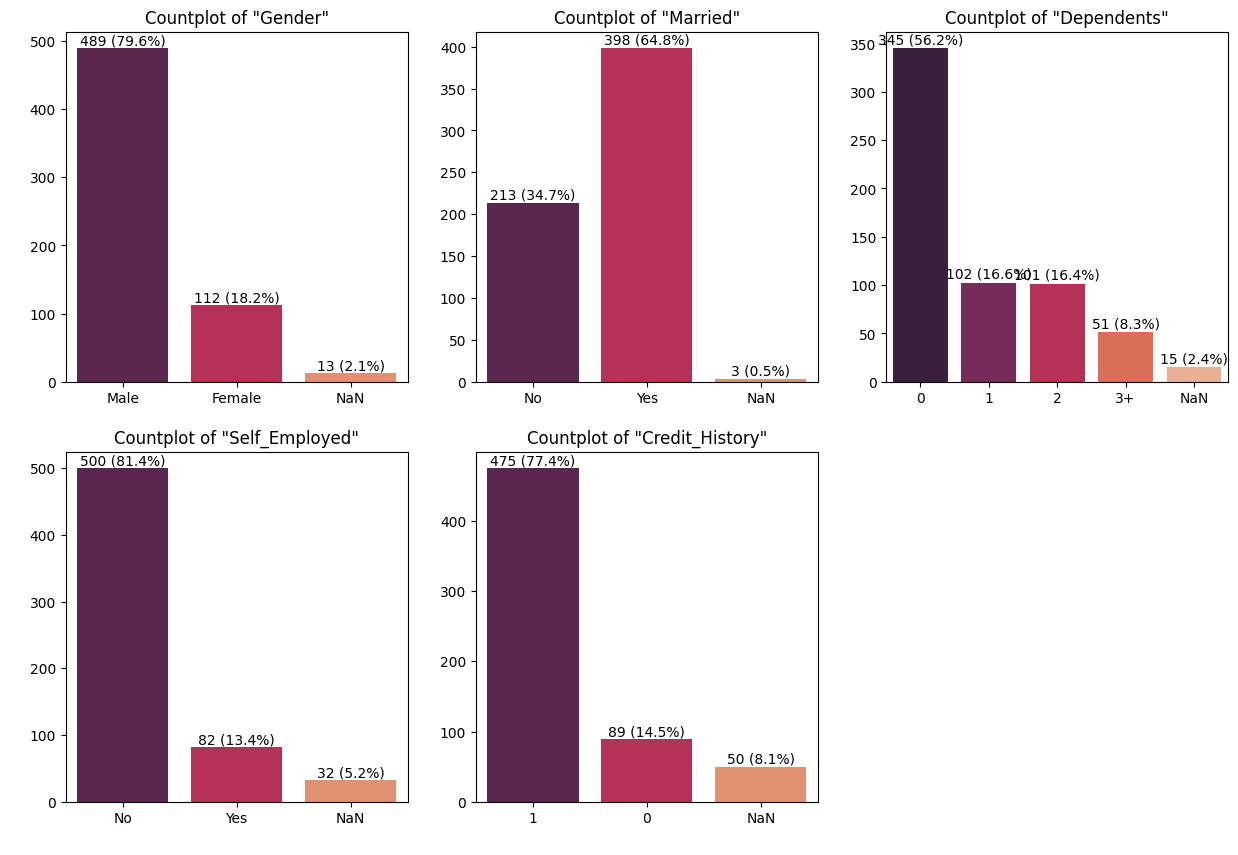

In [13]:
print('Number of rows in the dataframe with categorical null values:', df[df.isnull().any(axis=1)].shape[0])

df_categorical_columns_nan = df[categorical_columns_nan].copy()
df_categorical_columns_nan = df_categorical_columns_nan.fillna("NaN")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, column in enumerate(categorical_columns_nan):
    row = i // 3 
    col = i % 3
    
    sns.countplot(x=column, data=df_categorical_columns_nan, palette="rocket", hue=column, ax=axes[row, col])

    total_entries = df_categorical_columns_nan[column].count()
    for p in axes[row, col].patches:
        height = p.get_height()
        axes[row, col].text(p.get_x() + p.get_width() / 2., height + 5, f'{int(height)} ({height / total_entries:.1%})', ha='center')
    
    axes[row, col].set_title(f'Countplot of "{column}"')
    axes[row, col].set_xlabel(' ')
    axes[row, col].set_ylabel(' ')


fig.delaxes(axes.flatten()[len(categorical_columns_nan)])

plt.show()

Since the missing values do not have a strong representation in the columns, they will be deleted. If they were representative, the following methods could be applied:
- Adding a weight variable
- Creating a new category
- Using a machine learning model for predicting the NaN category.

In [14]:
df = df.dropna()

In [15]:
print(df.shape)
df.isnull().sum().to_frame().rename(columns= {0:'NaN values'}).style.applymap(highlight_nans)

(511, 12)


,NaN values
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0
Credit_History,0


## Duplicated values

In [16]:
print('Total of duplicated values:', df[df.duplicated()].shape[0])

Total of duplicated values: 0


In [17]:
df.sample(10)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
297,Female,Yes,1,Graduate,No,4666,0.0,135,360,1,Urban,Y
399,Female,No,0,Graduate,No,1500,1800.0,103,360,0,Semiurban,N
607,Male,Yes,2,Not Graduate,No,3987,1411.0,157,360,1,Rural,Y
214,Male,Yes,0,Graduate,No,3173,3021.0,137,360,1,Urban,Y
403,Female,No,0,Not Graduate,No,1963,0.0,53,360,1,Semiurban,Y
242,Male,No,0,Graduate,No,2965,5701.0,155,60,1,Urban,Y
351,Male,No,0,Graduate,No,8750,4167.0,308,360,1,Rural,N
179,Male,No,0,Not Graduate,No,2333,1451.0,102,480,0,Urban,N
6,Male,Yes,0,Not Graduate,No,2333,1516.0,95,360,1,Urban,Y
315,Male,Yes,1,Not Graduate,No,3399,1640.0,111,180,1,Urban,Y


## Data Distribution

### Numerical features

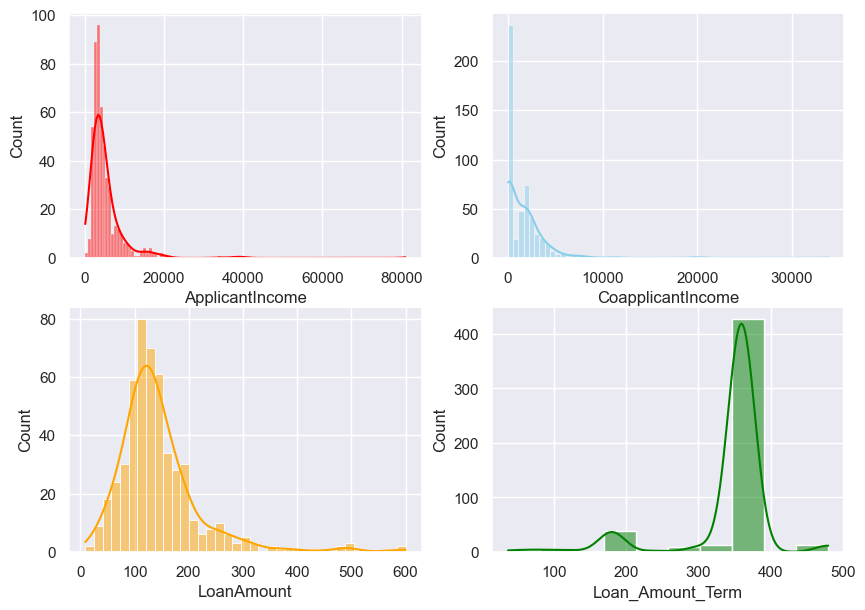

In [85]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

sns.histplot(data=df, x="ApplicantIncome", kde=True, ax=axs[0, 0], color='red')
sns.histplot(data=df, x="CoapplicantIncome", kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x="LoanAmount", kde=True, ax=axs[1, 0], color='orange')
sns.histplot(data=df, x="Loan_Amount_Term", kde=True, ax=axs[1, 1], color='green');

c:\Users\guilh\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arrays\masked.py:559: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs2, **kwargs)


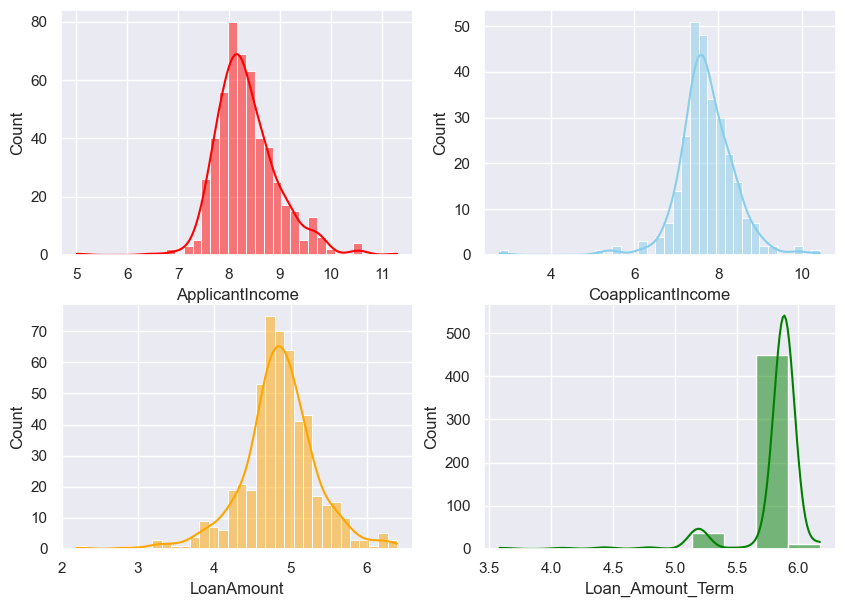

In [122]:
fig, axs = plt.subplots(2, 2, figsize=(10, 7))

sns.histplot(data=df, x=np.log(df['ApplicantIncome']), kde=True, ax=axs[0, 0], color='red')
sns.histplot(data=df, x=np.log(df["CoapplicantIncome"]), kde=True, ax=axs[0, 1], color='skyblue')
sns.histplot(data=df, x=np.log(df["LoanAmount"]), kde=True, ax=axs[1, 0], color='orange')
sns.histplot(data=df, x=np.log(df["Loan_Amount_Term"]), kde=True, ax=axs[1, 1], color='green');

C:\Users\guilh\AppData\Local\Temp\ipykernel_17708\1964906599.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='Greens', ax=axs[0])
C:\Users\guilh\AppData\Local\Temp\ipykernel_17708\1964906599.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method='spearman'), annot=True, cmap='Reds', ax=axs[1])


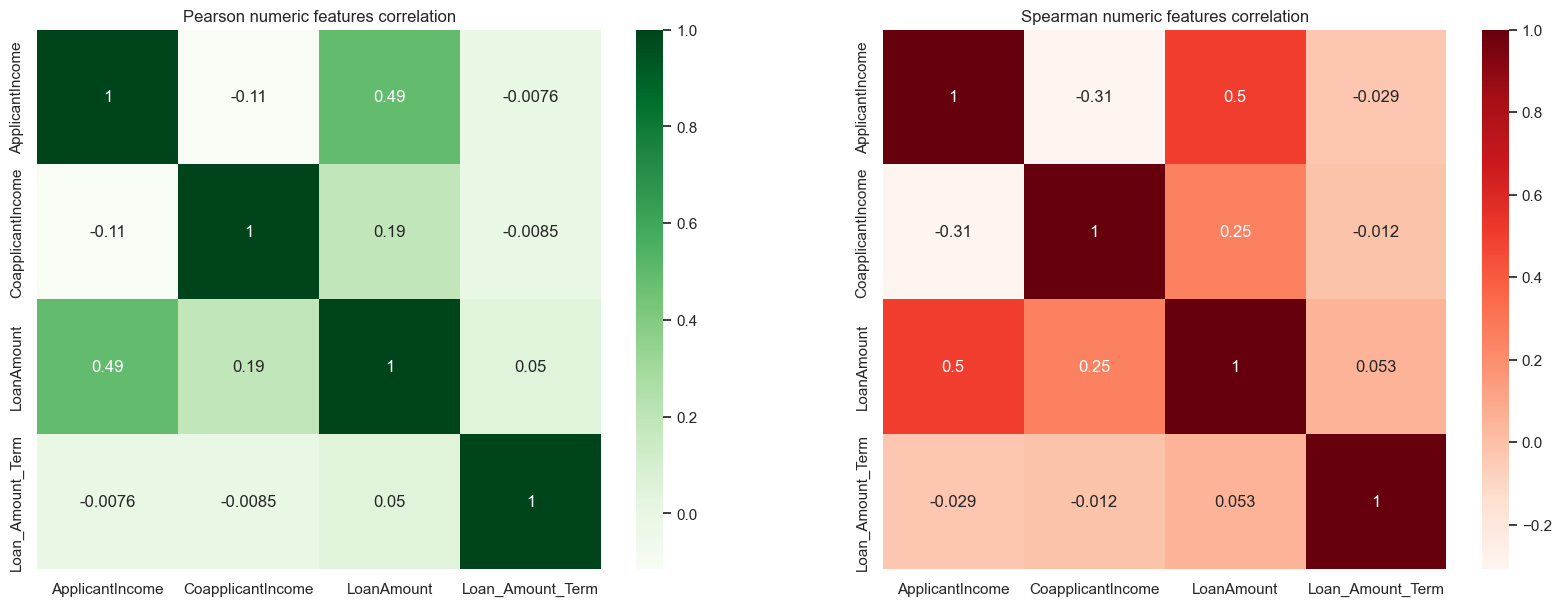

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7))

sns.heatmap(df.corr(), annot=True, cmap='Greens', ax=axs[0])
axs[0].set_title('Pearson numeric features correlation')

sns.heatmap(df.corr(method='spearman'), annot=True, cmap='Reds', ax=axs[1])
axs[1].set_title('Spearman numeric features correlation')

plt.show()

C:\Users\guilh\AppData\Local\Temp\ipykernel_17708\4042725499.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Loan_Status", y="ApplicantIncome", data=df, palette=({'Y':'mediumaquamarine','N':'lightcoral'}));


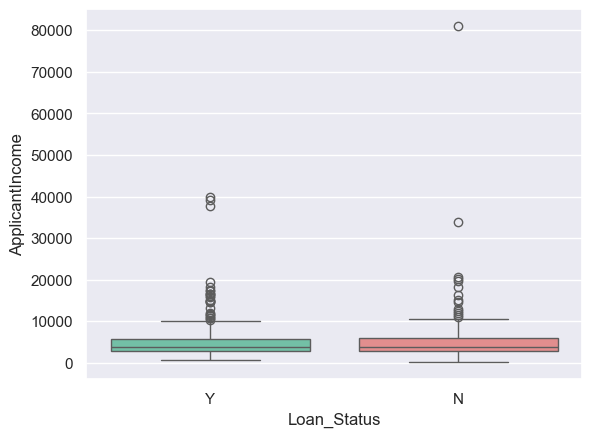

In [59]:
sns.boxplot(x="Loan_Status", y="ApplicantIncome", data=df, palette=({'Y':'mediumaquamarine','N':'lightcoral'}));

### Categorical features

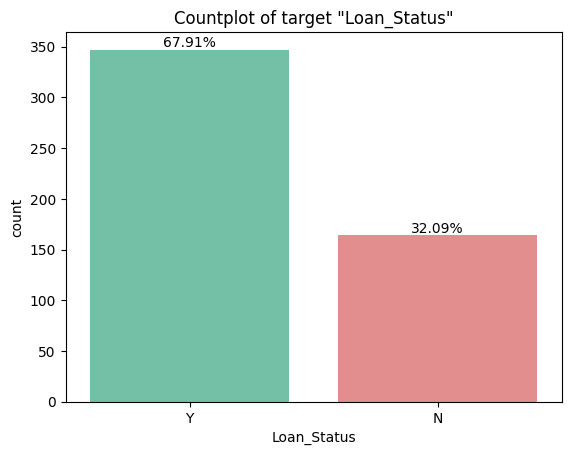

In [18]:
ax = sns.countplot(x='Loan_Status', data=df, hue='Loan_Status', palette=({'Y':'mediumaquamarine','N':'lightcoral'}))

total = len(df['Loan_Status'])

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:.2f}%'.format((height / total) * 100), ha="center")

plt.title('Countplot of target "Loan_Status"')
plt.show()

Due to the target's imbalance, I will balance it later using the SMOTE method.

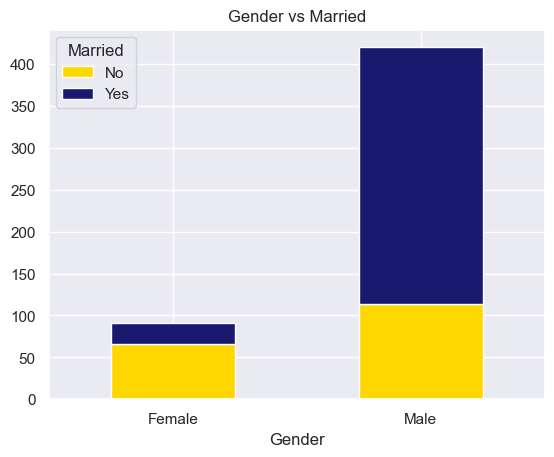

In [75]:
pd.crosstab(df['Gender'], df['Married']).plot(kind='bar', stacked=True, color=['gold','midnightblue'])
plt.title('Gender vs Married')
plt.xticks(rotation=0)
plt.show()

Most male applicants are already married compared to female applicants. Additionally, the number of unmarried male applicants is higher compare to unmarried female applicants.

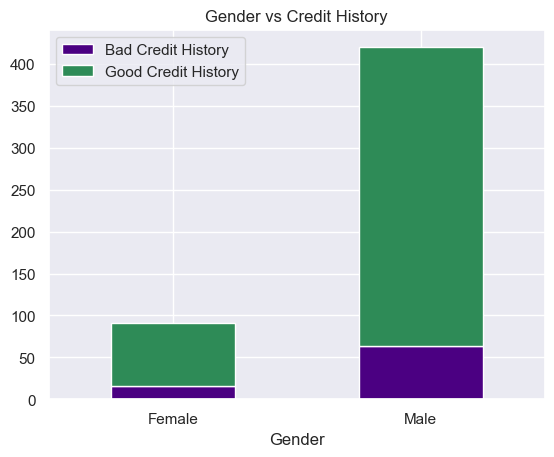

In [80]:
pd.crosstab(df['Gender'], df['Credit_History']).plot(kind='bar', stacked=True, color=['indigo','seagreen'])
plt.title('Gender vs Credit History')
plt.legend(["Bad Credit History", "Good Credit History"])
plt.xticks(rotation=0)
plt.show()

The number of applicants with a good credit history is higher for both men and women.

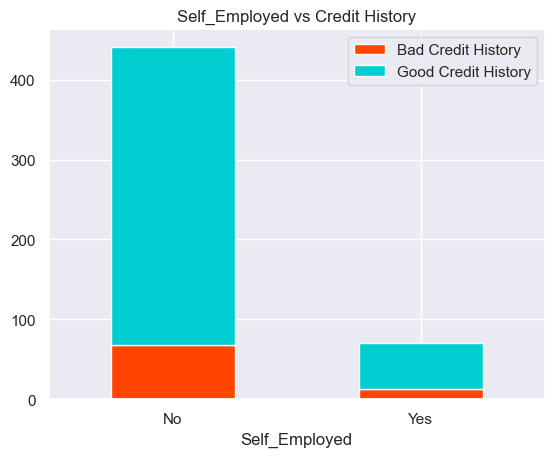

In [84]:
pd.crosstab(df['Self_Employed'], df['Credit_History']).plot(kind='bar', stacked=True, color=['orangered','darkturquoise'])
plt.title('Self_Employed vs Credit History')
plt.legend(["Bad Credit History", "Good Credit History"])
plt.xticks(rotation=0)
plt.show()

Most not self employed applicants have good credit compared to self employed applicants.

# Feature Engineering

## Dummy features

### Nominal features

In [ ]:
df = pd.get_dummies(data=df, columns=['Gender','Married','Education','Self_Employed','Credit_History','Loan_Status','Property_Area'], drop_first=True)

# Rename columns name
rename_dummies_columns = {'Gender_Male': 'Gender', 'Married_Yes': 'Married', 
                            'Education_Not Graduate': 'Education', 'Self_Employed_Yes': 'Self_Employed',
                            'Credit_History_1': 'Credit_History', 'Loan_Status_Y': 'Loan_Status'}
       
df.rename(columns=rename_dummies_columns, inplace=True)

### Ordinal features (Dependents)

In [ ]:
label_encoder = LabelEncoder()

df['Dependents'] = label_encoder.fit_transform(df['Dependents'])